# Machine Learning for Equipment Failure Prediction and Equipment Maintenance (PM)

For more information on the topic please see the following article.

<a href="https://medium.com/swlh/machine-learning-for-equipment-failure-prediction-and-predictive-maintenance-pm6/" target="_blank" rel="noopener noreferrer">Machine Learning for Equipment Failure Prediction and Predictive Maintenance</a>

Published July 2020, Greatly revised on February 2021.

In this notebook, I walk through a predictive maintenance problem in great detail.  These types of issues can be tricky for several reasons.  The first six sections deal with building a model.  The last sections deal with evaluating model effectiveness and ensuring it will be effective when deployed in production.


When it comes to dealing with machines that require periodic maintenance, there are generally three possible outcomes.

One, you can maintain a machine too frequently. In other words, the machine gets maintenance when it is not required. In this scenario, you are throwing money out the window, wasting resources providing unnecessary maintenance. For example, you could change the oil in your car every single day. This is not optimal, and you will waste a lot of money on unnecessary maintenance.

Two, you don’t maintain your machine frequently enough. Failing to maintain a machine means that the machine will break while operating. Here, the costs could be substantial. Not only do you have the repair costs, but also costs associated with lost production. If a machine on the assembly line goes down, the line cannot produce anything. No production means lost profit. Also, you will incur legal and medical costs if injuries occurred as a result of the failure.

Three, a machine is maintained when it needs maintenance. This is obviously the better alternative of the three. Note, that that there is still a cost associated with timely maintenance.

So, we need to maintain machines when they need maintenance, right? Unfortunately, this is easier said than done. Fortunately, we can use predictive maintenance (PM) to predict when machines need maintenance.

I should also mention that most machines come with manufacturer recommendations on maintenance. The problem with manufacturer recommendations is that they represent an average. For example, cars on average need an oil change every 3,000 miles, but how frequently does your car need an oil change? It may be more or less than 3,000 miles depending on several factors, including where your drive, how you drive, and how frequently you drive.

Predictive maintenance (PM) can tell you, based on data, when a machine requires maintenance. An effective PM program will minimize under and over-maintaining your machine. For a large manufacturer with thousands of machines, being precise on machine maintenance can save millions of dollars every year.

In this article, I will examine a typical Predictive Maintenance (PM) use case. As I walk through this example, I will describe some of the issues that arise with PM problems and suggest ways to solve them.

An important note about the data used in this exercise. It is entirely fake. I created the data based on my experience of dealing with these types of problems. Although it is entirely artificial, I believe the data and use case is very realistic and consistent with many real PM problems.






The firm in our use case provided a sample of data that includes 421 machines that failed over two years. They spent 11.766M dollars on maintenance, most of which came from running machines until failure.

Here is a summary of the maintained or repaired machines over the last two years.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")

From the data above, it currently costs the firm about $28,000 per failed or maintained machine. Our goal is to lower this cost.

In the chart above, Timely Maintenance costs more than Unnecessary Maintenance. There is a good reason for this. For this machine, unnecessary maintenance means that that machine was moved off-line and checked, but the part in question showed insufficient wear to replace. Because parts were not replaced, there are no material costs, only labor.

Note that this company does very little predictive maintenance. Most of the time, they just run the machines to failure. Also, note that these machines will break in four to eight years if they don’t receive maintenance. When they fail, they must be pulled off-line and repaired.

Our goal is to show the firm how a Predictive Maintenance program can save them money. To do this, we will build a predictive model that predicts machine failure within 90 days of actual failure. Note that an appropriate failure window will always depend on the context of the problem. If a machine breaks without maintenance in 6 months, a three-month window makes no sense. Here, where a machine will run between 4 to 6 years without maintenance, a 90-day window is reasonable.

Our objective is to develop a solution that will lower the costs of failure. Again, it currently costs the firm about 28,000 per machine. We will attempt to reduce this cost.

Note that I developed this exercise in Watson Studio on the IBM Cloud.  If you have issues running the notebook, please set up a free account on IBM Cloud and try it there.

See more about <a href="https://www.ibm.com/cloud/watson-studio" target="_blank" rel="noopener noreferrer">IBM Watson Studio</a>.



## Table of Contents

1. [Getting Setup](#setup1)<br>
 
2. [Data Exploration](#explore)<br>

3. [Data Transformation and Feature Engineering](#trans)<br>
 
4. [Dealing with the Small Number of Failures](#small)<br>
    4.1 [Expand the Failure Window](#window)<br>
    4.2 [Create Testing, Training and Validation Groups](#groups)<br>
    4.3 [SMOTE the Training Data](#smote)<br>
5. [More Data Transformations and Feature Engineering](#more)<br>
6. [Build the Model on the Balanced Data Set](#build)<br>
7. [Evaluate model on the unbalanced training and testing data set](#score)<br>
    7.1 [Evaluate the model using an AUC and accuacy metrics](#7.1)<br>
    7.2 [Evaluating with a Confusion Matrix](#7.2)<br>
    7.3 [Using Heuristics to Define a False Positive, True Positive, False Negative and True Negative](#7.3)<br>
    7.4 [7.4 Apply Model and Heuristics the Training, Testing and Validation Data Sets](#7.4)<br>
11. [Conclusions](#conc)<br>

### 1.0 Getting Set-Up <a id="setup1"></a>

 Install all of the relevant Python Libraries

In [2]:

#!pip install imbalanced-learn -- upgrade
!pip install plotly --upgrade
!pip install chart-studio --upgrade




     |████████████████████████████████| 23.9 MB 10.3 MB/s eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 4.14.3
    Uninstalling plotly-4.14.3:
      Successfully uninstalled plotly-4.14.3
     |████████████████████████████████| 64 kB 3.6 MB/s  eta 0:00:01


In [3]:
!pip install scikit-learn==0.23.1
!pip install imbalanced-learn==0.7.0

     |████████████████████████████████| 6.7 MB 12.5 MB/s eta 0:00:01��████    | 5.9 MB 12.5 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
     |████████████████████████████████| 167 kB 12.9 MB/s eta 0:00:01


Import required libraries

In [4]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly as plotly
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import types
import pandas as pd

def __iter__(self): return 0




Import the data from GitHub.

In [5]:
#Remove the data if you run this notebook more than once
!rm equipment_failure_data_1.csv

rm: cannot remove 'equipment_failure_data_1.csv': No such file or directory


In [6]:
#import first half from github
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv

--2021-10-18 11:20:11--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11219474 (11M) [text/plain]
Saving to: ‘equipment_failure_data_1.csv’

equipment_failure_d 100%[===================>]  10.70M  --.-KB/s    in 0.08s   

2021-10-18 11:20:11 (142 MB/s) - ‘equipment_failure_data_1.csv’ saved [11219474/11219474]



In [7]:
# Convert csv to pandas dataframe
pd_data_1 = pd.read_csv("equipment_failure_data_1.csv", sep=",", header=0)

In [8]:
#Remove the data if you run this notebook more than once
!rm equipment_failure_data_2.csv

rm: cannot remove 'equipment_failure_data_2.csv': No such file or directory


In [9]:
#Import the second half from github
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv

--2021-10-18 11:20:13--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11762512 (11M) [text/plain]
Saving to: ‘equipment_failure_data_2.csv’

equipment_failure_d 100%[===================>]  11.22M  --.-KB/s    in 0.08s   

2021-10-18 11:20:14 (148 MB/s) - ‘equipment_failure_data_2.csv’ saved [11762512/11762512]



In [10]:
# convert to pandas dataframe
pd_data_2 = pd.read_csv("equipment_failure_data_2.csv", sep=",", header=0)

In [11]:
#concatenate the two data files into one dataframe
pd_data=pd.concat([pd_data_1, pd_data_2])



### 2.0 Data Exporation <a id="explore"></a>

In [12]:
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


Now that we have the data imported into a Jupiter Notebook, we can explore it. Here is metadata explaining all of the fields in the data set.

ID — ID field that represents a specific machine.

DATE — The date of the observation.

REGION_CLUSTER — a field that represents the region in which the machine resides.

MAINTENANCE_VENDOR — a field that represents the company that provides maintenance and service to the machine.

MANUFACTURER — the company that manufactured the equipment in question.

WELL_GROUP — a field representing the type of machine.

EQUIPMENT_AGE — Age of the machine, in days.

S15 — A Sensor Value.

S17 — A Sensor Value.

S13 — A Sensor Value.

S16 — A Sensor Value.

S19 — A Sensor Value.

S18 — A Sensor Value.

S8 — A Sensor Value.

EQUIPMENT_FAILURE — A ‘1’ means that the equipment failed. A ‘0’ means the equipment did not fail.

Our first goal in this exercise is to build a model that predicts equipment failure. In other words, we will use the other variables in the data frame to predict EQUIPMENT_FAILURE.

Now we will walk through the data.




Examine the number of rows and columns.  The data has 307,751 rows and 16 columns.

In [13]:

pd_data.shape

(307751, 16)

There are 421 machines in the data set.

In [14]:

xxxx = pd.DataFrame(pd_data.groupby(['ID']).agg(['count']))
xxxx.shape

(421, 15)

there are 731 unique dates in the data set.

In [15]:

xxxx = pd.DataFrame(pd_data.groupby(['DATE']).agg(['count']))
xxxx.shape

(731, 15)

We have 731 unique dates.  So if we have 421 machines and 731 unique dates, we should have 307,751 total records.  Based on the .shape command, we have one record per machine per date value.  There are no duplicates in the data frame.



And to triple confirm, remove all duplicates and count the rows again.

In [16]:
df_failure_thingy=pd_data
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['ID','DATE'])
df_failure_thingy.shape


(307751, 16)

Look for null values in the fields -- There are none.

In [17]:
pd_data.isnull().sum(axis = 0)

ID                    0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

Now let’s examine the dependent variable in more detail. It appears that out of 307,751 records, we only have 421 failures. This corresponds to a failure rate of about .14%. In other words, for every failure, you have over 700 non-failures. This data set is very unbalanced. Later in this article, I will use a few techniques to mitigate the impact of a small number of observed failures.

In [18]:
xxxx = pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))
xxxx

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


We can also explore the data with descriptive statistics.

In [19]:

pd_data.describe()

,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
count,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000
mean,100310.826603,4.543943,14.585192,80.265541,35.018249,4675.848252,7.972097,9.069123,137.963064,0.001368,144.665715,2524.192399
std,177.574390,2.284121,8.817056,85.804273,14.446585,2521.074632,2.321949,16.898887,238.890128,0.036961,240.773926,3158.930976
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.490000,0.000000
25%,100161.000000,3.000000,7.694100,0.000000,28.200000,3209.000000,6.621500,0.900000,11.798276,0.000000,9.250000,721.000000
50%,100311.000000,5.000000,11.661600,31.680000,34.940000,4237.047619,8.004000,4.200000,38.200000,0.000000,53.080000,1113.000000
75%,100467.000000,6.000000,22.560000,160.080000,41.610000,5743.000000,9.460000,10.600000,150.900000,0.000000,165.092608,2784.000000
max,100617.000000,8.000000,59.040000,2555.520000,592.890000,52767.000000,24.600000,511.000000,4151.700000,1.000000,2068.110000,15170.000000


Examine a simple correlation of the independent variable with the dependent variable.  

In [20]:
xxx=pd_data.corr( method='pearson')

xxx=xxx[['EQUIPMENT_FAILURE']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['EQUIPMENT_FAILURE'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])

In [21]:
xxx

,EQUIPMENT_FAILURE,ABS_EQUIPMENT_FAILURE
EQUIPMENT_FAILURE,1.000000e+00,1.000000e+00
S15,-6.036352e-02,6.036352e-02
S17,-3.429070e-02,3.429070e-02
S18,9.765002e-03,9.765002e-03
S13,-8.617761e-03,8.617761e-03
S5,-7.189979e-03,7.189979e-03
S8,6.517148e-03,6.517148e-03
S16,-6.138895e-03,6.138895e-03
S19,-6.087474e-03,6.087474e-03
AGE_OF_EQUIPMENT,4.733368e-04,4.733368e-04


### 3.0 Data transformations and Feature Engineering <a id="trans"></a>

Next, we can transform our data for a machine learning model. Specifically, we will create running summaries of the sensor values. Running summaries of sensor values are often useful in predicting equipment failure. For example, if a temperature gauge indicates a machine is warmer than average for the last five days, it may mean something is wrong.

Remember that we are working with a panel data set. That is, we have multiple machines measured over two years. As we create our running summaries, we have to make sure that our summaries do not include more than one machine. For example, if we create a ten-day moving average, we do not want the first nine days of a machine to have values from the previous machine.

Note that I create twenty-one-day summaries in this example. This works for this use case, but it may be advantageous to use more or different time intervals for other situations.


Convert dates from character to date.

In [22]:


pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])





Create a new field called “flipper” that indicates when the id changes as the data are sorted by ID and DATE in ascending order. We will use this in a few other transformations.

In [23]:
pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

pd_data['flipper'] = np.where((pd_data.ID != pd_data.ID.shift(1)), 1, 0)
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,flipper
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,1
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881,0
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882,0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883,0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884,0


Running summaries are often useful transformations for these types of problems.  For example, a running mean would be the average value over the last x days.  X, in this case, is the feature window.  The feature window is a parameter that depends on the context of the business problem.  I am setting the value to 21 days, but this may or may not work for your business problem.

In [24]:
#define your feature window. This is the window by which we will aggregate our sensor values.
feature_window=21

Calculate the number of days from the first day a machine appears to the current day. This field will be called “TIME_SINCE_START” Also, create a variable called “too_soon.” When “too_soon” is equal to 1, we have less than 21 days (feature_window) of history for the machine.

We will use these new variables to create a running mean, median, max, and min. 


In [25]:
dfx=pd_data

In [26]:
#Select the first record of each machine

starter=dfx[dfx['flipper'] == 1]

starter=starter[['DATE','ID']]

In [27]:
#rename date to start_date
starter=starter.rename(index=str, columns={"DATE": "START_DATE"})

In [28]:
#convert START_DATE to date
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

In [29]:
#Merge START_DATE to the original data set

dfx=dfx.sort_values(by=['ID', 'DATE'], ascending=[True, True])
starter=starter.sort_values(by=['ID'], ascending=[True])
dfx =dfx.merge(starter, on=['ID'], how='left')

In [30]:
# calculate the number of days since the beginning of each well. 
dfx['C'] = dfx['DATE'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['C'] / np.timedelta64(1, 'D')
dfx=dfx.drop(columns=['C'])
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window) , 1, 0)

Create a running mean, max, min, and median for the sensor variables.

In [31]:
dfx['S5_mean'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S5)
dfx['S5_median'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).median()) , dfx.S5)
dfx['S5_max'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).max()) , dfx.S5)
dfx['S5_min'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).min()) , dfx.S5)


dfx['S13_mean'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S13)
dfx['S13_median'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).median()) , dfx.S13)
dfx['S13_max'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).max()) , dfx.S13)
dfx['S13_min'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).min()) , dfx.S13)


dfx['S15_mean'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S15)
dfx['S15_median'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).median()) , dfx.S15)
dfx['S15_max'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).max()) , dfx.S15)
dfx['S15_min'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).min()) , dfx.S15)

dfx['S16_mean'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S16)
dfx['S16_median'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).median()) , dfx.S16)
dfx['S16_max'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).max()) , dfx.S16)
dfx['S16_min'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).min()) , dfx.S16)


dfx['S17_mean'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S17)
dfx['S17_median'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).median()) , dfx.S17)
dfx['S17_max'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).max()) , dfx.S17)
dfx['S17_min'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).min()) , dfx.S17)

dfx['S18_mean'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S18)
dfx['S18_median'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).median()) , dfx.S18)
dfx['S18_max'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).max()) , dfx.S18)
dfx['S18_min'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).min()) , dfx.S18)



dfx['S19_mean'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S19)
dfx['S19_median'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).median()) , dfx.S19)
dfx['S19_max'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).max()) , dfx.S19)
dfx['S19_min'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).min()) , dfx.S19)


dfx.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,...,S17_max,S17_min,S18_mean,S18_median,S18_max,S18_min,S19_mean,S19_median,S19_max,S19_min
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,...,145.223448,145.223448,24.610345,24.610345,24.610345,24.610345,1.9,1.9,1.9,1.9
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,...,187.573214,187.573214,24.671429,24.671429,24.671429,24.671429,1.9,1.9,1.9,1.9
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,...,148.363704,148.363704,24.733333,24.733333,24.733333,24.733333,2.0,2.0,2.0,2.0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,...,133.660000,133.660000,24.773077,24.773077,24.773077,24.773077,2.0,2.0,2.0,2.0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,...,197.181600,197.181600,24.808000,24.808000,24.808000,24.808000,1.5,1.5,1.5,1.5


Another useful transformation is to look for sudden spikes in sensor values. This code creates a value indicating how far the current value is from the immediate norm.

In [32]:
dfx['S5_chg'] = np.where((dfx.S5_mean == 0),0 , dfx.S5/dfx.S5_mean)


dfx['S13_chg'] = np.where((dfx.S13_mean == 0),0 , dfx.S13/dfx.S13_mean)

dfx['S15_chg'] = np.where((dfx.S15_mean==0),0 , dfx.S15/dfx.S15_mean)
dfx['S16_chg'] = np.where((dfx.S16_mean == 0),0 , dfx.S16/dfx.S16_mean)
dfx['S17_chg'] = np.where((dfx.S17_mean == 0),0 , dfx.S17/dfx.S17_mean)
dfx['S18_chg'] = np.where((dfx.S18_mean == 0),0 , dfx.S18/dfx.S18_mean)
dfx['S19_chg'] = np.where((dfx.S19_mean == 0),0 , dfx.S19/dfx.S19_mean)

In [33]:
#copy the data set to the original name
pd_data=dfx

### 4.0 Dealing with the small number of failures. <a id="small"></a>

#### 4.1 Expand the Failure (Target) Window <a id="window"></a>

Machines are engineered to last. If something breaks all the time, you won’t buy it, would you?

Because machines generally last a long time, we typically do not have many examples of failure. This means the data sets we use in PM are almost always unbalanced. 

One way to increase the number of failures is to expand the failure or target window. That is, make the dependent variable, not just the day the equipment failed but the 28 days (or another appropriate interval) leading up to the failure.

In this example, I use a 28-day target window. We will use the 28 days leading up to a failure as the dependent variable in our model.


In [34]:
target_window=28

Sort the data and reset the index.

In [35]:
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
pd_data.reset_index(level=0, inplace=True)

Create a new data frame that contains the failure records.  Rename DATE to FAILURE_DATE

In [36]:


df_failure_thingy=pd_data[pd_data['EQUIPMENT_FAILURE'] == 1]

df_failure_thingy=df_failure_thingy[['DATE','ID']]

df_failure_thingy=df_failure_thingy.rename(index=str, columns={"DATE": "FAILURE_DATE"})

pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
df_failure_thingy=df_failure_thingy.sort_values(by=['ID'], ascending=[True])


Append the FAILURE_DATE to each ID.

In [37]:


pd_data =pd_data.merge(df_failure_thingy, on=['ID'], how='left')

For each record, calculate the number of days until failure.

In [38]:


pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

pd_data['FAILURE_DATE'] = pd.to_datetime(pd_data['FAILURE_DATE'])
pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
pd_data['C'] = pd_data['FAILURE_DATE'] - pd_data['DATE']

pd_data['TIME_TO_FAILURE'] = pd_data['C'] / np.timedelta64(1, 'D')

Clean up and sort the records by ID and DATE

In [39]:
pd_data=pd_data.drop(columns=['index'])

In [40]:
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])



In [41]:
pd_data.reset_index(inplace=True)


In [42]:
pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0
2,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0
3,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0
4,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0


Create a new variable, FAILURE_TARGET.  It is equal to 1 if the record proceeds a failure by "failure_window" days or less.

In [43]:
pd_data['FAILURE_TARGET'] = np.where(((pd_data.TIME_TO_FAILURE < target_window) & ((pd_data.TIME_TO_FAILURE>=0))), 1, 0)

pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0,0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0,0
2,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0,0
3,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0,0
4,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0,0


In [44]:
tips_summed = pd_data.groupby(['FAILURE_TARGET'])['S5'].count()
tips_summed

FAILURE_TARGET
0    296011
1     11740
Name: S5, dtype: int64

The new field occurs about 4% of the time.

In [45]:
pd_data['FAILURE_TARGET'].mean()

0.03814772332177637

Now we have 11,740 target observations. This is better, but the data set is far from balanced. In the next section, we will use SMOTE to increase the number of failures synthetically. However, let’s split our data into training, testing, and a validation sample before we do that.

#### 4.2 Create the Testing, Training and Validation Groupings <a id="groups"></a>

Because we are dealing with a panel data set (cross-sectional time-series), it is better not to take a random sample of all records. Doing so would put the records from one machine in all three sample data sets. To avoid this, we’ll randomly select IDs and place all of the records for each machine in either the training, testing, or validation data set.

In [46]:
#Get a Unique List of All IDs 


aa=pd_data

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape


(421, 1)

Create a new variable with a random number between 0 and 1

In [47]:
np.random.seed(42)

In [48]:
pd_id['wookie'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000

In [49]:

pd_id=pd_id[['ID', 'wookie']]

Give each record a 30% chance of being in the validation, a 35% chance of being in the testing, and a 35% chance of being in the training data set.


In [50]:
pd_id['MODELING_GROUP'] = np.where(((pd_id.wookie <= 0.35)), 'TRAINING', np.where(((pd_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))

This is how many machines fall in each group.

In [51]:
tips_summed = pd_id.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       149
TRAINING      146
VALIDATION    126
Name: wookie, dtype: int64

Append the Group of each id to each individual record.

In [52]:
pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])

In [53]:
pd_data =pd_data.merge(pd_id, on=['ID'], how='inner')

pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET,wookie,MODELING_GROUP
0,0,100001,2014-12-02,G,O,Y,1,11.088,145.223448,39.34,...,1.000000,1.0,1.000000,1.000000,2015-04-24,143 days,143.0,0,0.727,TESTING
1,1,100001,2016-03-29,G,O,Y,1,18.960,0.000000,38.87,...,1.080334,0.0,0.909801,0.613483,2015-04-24,-340 days,-340.0,0,0.727,TESTING
2,2,100001,2016-03-30,G,O,Y,1,29.040,0.000000,37.36,...,1.093691,0.0,0.906040,0.677419,2015-04-24,-341 days,-341.0,0,0.727,TESTING
3,3,100001,2016-03-31,G,O,Y,1,18.000,0.000000,38.81,...,0.910905,0.0,0.919466,0.695035,2015-04-24,-342 days,-342.0,0,0.727,TESTING
4,4,100001,2016-04-01,G,O,Y,1,26.160,0.000000,39.47,...,1.160104,0.0,0.932363,0.690141,2015-04-24,-343 days,-343.0,0,0.727,TESTING


This is how many records are in each group.

In [54]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       108919
TRAINING      106726
VALIDATION     92106
Name: wookie, dtype: int64

This is how many failure targets are in each group.

In [55]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()
tips_summed

MODELING_GROUP
TESTING       4151
TRAINING      4071
VALIDATION    3518
Name: FAILURE_TARGET, dtype: int64

Create a separate data frame for the training data.  We will use this data set to build the model.

In [56]:
df_training=pd_data[pd_data['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_training.shape

(106726, 56)

Create a separate data frame for the training and testing data sets.  We will use this to tweak our modeling results.

In [57]:
df_train_test=pd_data[pd_data['MODELING_GROUP'] != 'VALIDATION']

df_train_test=df_train_test.drop(columns=['wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_train_test.shape

(215645, 58)

Create a separate data frame for all the data. We will use this to validate the model and compare the accuracy of all groups.

In [58]:
df_total=pd_data.drop(columns=['C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_total.shape

(307751, 57)

#### 4.3 SMOTE the Training Data <a id="smote"></a>

Note that we are only balancing the training data set. You may be asking why. Remember that our goal is to build a model the represents reality, right? When we SMOTE the data, we change the failure rate to 50%. This is nowhere near what we see in the actual machine data.  Thus, it makes sense to build the model on the SMOTE data but evaluate it on the unaltered data. The unaltered data will be a better reflection of what to expect when you deploy the model to production.

Define the Training features and Target.

In [59]:
training_features=df_training[['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5',
 'S16','S19','S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median',
 'S15_max','S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min','S19_mean','S19_median','S19_max','S19_min',
 'S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']]

In [60]:
training_target=df_training[['FAILURE_TARGET']]

Synthetically Balance the training data sets with a SMOTE algorithm. After we apply the SMOTE algorithm, we will have a balanced data set. 50% Failures and 50% Non-Failures. Note that this takes a while to run.

In [61]:
#uncomment these options if you want to expand the number of rows and columns that appear visually on the screen.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [62]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])

In [63]:
x_res, y_res = smx.fit_sample(training_features, training_target.values.ravel())

Convert the SMOTE output back to complete data frames with independent and dependent variables.  Examine the results.

Format the Independent Variables.

In [64]:
df_x=pd.DataFrame(x_res)

df_x.columns = [
 'REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5','S16','S19',
 'S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median','S15_max',
 'S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min',
 'S19_mean','S19_median','S19_max','S19_min','S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']
df_x.head()

,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,S16,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,D,L,R,6,1308,15.5184,188.10,36.29,4318.0,8.0073,...,22.4,28.9,22.4,0.989654,0.989779,1.208706,0.913224,1.150727,0.995684,0.911805
1,D,L,R,6,1307,10.3032,149.24,36.78,4377.0,7.0766,...,22.4,28.9,22.4,1.001165,1.001141,0.800762,0.799231,0.931453,0.991996,0.911805
2,D,L,R,6,1306,11.4480,187.45,35.84,4265.0,8.0259,...,22.4,28.9,22.4,0.974444,0.974443,0.886546,0.906484,1.158515,0.985806,0.911805
3,D,L,R,6,1302,15.1368,148.33,37.53,4466.0,8.7163,...,22.4,28.9,22.4,1.015319,1.015344,1.168344,0.992329,0.922866,0.973863,0.911805
4,D,L,R,6,1304,14.3736,179.30,36.31,4321.0,7.9396,...,22.4,28.9,22.4,0.983099,0.983085,1.094500,0.902220,1.132530,0.980886,0.911805


Format the Dependent Variable.

In [65]:
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

Check that the dependent variable is balanced.  It is.

In [66]:
df_y.mean(axis = 0) 

FAILURE_TARGET    0.5
dtype: float64

Merge the dependent and independent variables post SMOTE into a data frame.

In [67]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.head()

,FAILURE_TARGET,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,0,D,L,R,6,1308,15.5184,188.10,36.29,4318.0,...,22.4,28.9,22.4,0.989654,0.989779,1.208706,0.913224,1.150727,0.995684,0.911805
1,0,D,L,R,6,1307,10.3032,149.24,36.78,4377.0,...,22.4,28.9,22.4,1.001165,1.001141,0.800762,0.799231,0.931453,0.991996,0.911805
2,0,D,L,R,6,1306,11.4480,187.45,35.84,4265.0,...,22.4,28.9,22.4,0.974444,0.974443,0.886546,0.906484,1.158515,0.985806,0.911805
3,0,D,L,R,6,1302,15.1368,148.33,37.53,4466.0,...,22.4,28.9,22.4,1.015319,1.015344,1.168344,0.992329,0.922866,0.973863,0.911805
4,0,D,L,R,6,1304,14.3736,179.30,36.31,4321.0,...,22.4,28.9,22.4,0.983099,0.983085,1.094500,0.902220,1.132530,0.980886,0.911805


### 5.0 More data transformation and feature engineering <a id="more"></a>

Convert the categorical variables into binary dummy variables. We need to do this because the XGBT model (below) doesn't like categorical fields.

In [68]:
df_dv = pd.get_dummies(df_balanced['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_balanced= pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)



df_dv = pd.get_dummies(df_balanced['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


Execute the same transformation on the train_test data set.

In [69]:
df_dv = pd.get_dummies(df_train_test['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_train_test= pd.concat([df_train_test, df_dv], axis=1)


df_dv = pd.get_dummies(df_train_test['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)



df_dv = pd.get_dummies(df_train_test['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)


df_dv = pd.get_dummies(df_train_test['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)



And, also on the df_total data set.

In [70]:
df_dv = pd.get_dummies(df_total['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_total= pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_total = pd.concat([df_total, df_dv], axis=1)



df_dv = pd.get_dummies(df_total['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_total = pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_total = pd.concat([df_total, df_dv], axis=1)

### 6.0 Build the model on the balanced training data set <a id="build"></a>

In [71]:
# Remove the newly redundant categorical variables.  This are now represented by dummy variables.
df_balanced=df_balanced.drop(columns=['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP'])

In the balanced data set, separate the dependent and independent variables to feed the model development process.

In [72]:

features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET','EQUIPMENT_FAILURE']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])

independent=df_balanced.drop(columns=['FAILURE_TARGET'])

In [73]:
#make sure everything is numeric for simplicity
#independent = independent.apply(pd.to_numeric) 
#df_balanced = df_balanced.apply(pd.to_numeric)

Define model specs.

In [74]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

We are initializing our model with default model parameters. Note that we could probably improve the results by tweaking the parameters, but we will save that exercise for another day. 

In [75]:
xgb0 = XGBClassifier(
 objective= 'binary:logistic')



### 7.0 Evaluate the Model <a id="score"></a>

Probably the most confusing element of PM problems is building a realistic assessment of the model.  Because of timing and the small number of failures, understanding how the model will work once deployed in production is challenging. 

There are standard metrics for evaluating models like accuracy, AUC, and a confusion matrix.  In sections 7.1 and 7.2, I will show how, given the transformations we used to build our model and the complexity of the problem, these metrics do not give us a realistic view of model performance when deployed into production.  These standard metrics are definitely useful but are not sufficient.

In section 7.3, I lay out how I typically evaluate PM models.

#### 7.1 Evaluate the model using an AUC and accuacy metrics.<a id="7.1"></a>

First, we will evaluate the balanced training data with the default, a 50% cut-off.

For information on how to find the best cut-off for these types of problems, please see the following.

<a href="https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c" target="_blank" rel="noopener noreferrer">Determining a cut-off or threshold when working with a binary dependent target variable</a>


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy : 0.9978
AUC Score (Balanced): 0.999963


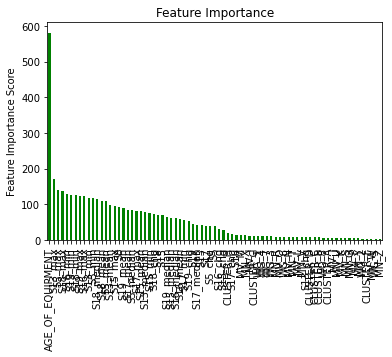

In [76]:
evaluate_model(xgb0, independent, dependent,features) 

With a cut-off of 50%, the accuracy is .835, and the AUC is .916 on the balanced training data.

These results are not bad, but there are a few issues.  Balancing the data significantly alters your base probability of failure.  Remember, before we applied the SMOTE algorithm, about 3.8% of our records were labeled as a FAILURE_TARGET.  After using the SMOTE algorithm, 50% were failures.  Because of this, I always prefer to evaluate the model on the unbalanced data.  Below we will examine the unbalanced data with a 50% cut-off.

Also, note that the predicted probability from our model is based on the balanced data.  This means it is not the true probability of failure.  The true probability of failure will be closer to .14%, not 50%.  The .14% comes from an average of the original failure variable. (EQUIPMENT_FAILURE).  

I am using the term "probability," perhaps a little too loosely in this article.  Just understand that the probability that the equipment will fail in the real world is about .14% (based on EQUIPMENT_FAILURE).  The likelihood of selecting a day within 28 days of a failure (FAILURE_TARGET) is about 3.8%.  The probability of a failure after we balance the data is 50%.
 

Isolate the unbalanced training and testing data sets.

In [77]:

df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

In [78]:


df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 0.9965
AUC Score (Train): 0.999906


With a 50% cut-off, we get an accuracy of .79 and an AUC of .89

Now, lets' try with a 67% cut-off. Probabilities larger than 67% are labeled as failures. Probabilities less than or equal to 67% are labeled as non-failures.  

In [79]:
df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .67)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 0.9981
AUC Score (Train): 0.999906


The accuracy improves quite a bit.  Now, let's apply the model to the testing data set.

In [80]:
df_testing['P_FAIL']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_FAIL'] = np.where(((df_testing.P_FAIL <= .67)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FAILURE_TARGET'].values, df_testing['Y_FAIL']))
print("AUC Score (Test): %f" % metrics.roc_auc_score(df_testing['FAILURE_TARGET'], df_testing['P_FAIL']))

Accuracy : 0.9584
AUC Score (Test): 0.524872


Before we go any further, let's take a step back and think about what we have done.  Ok, so our model validates with an accuracy of .942.  

Is that good or bad?  

At this point, I honestly have no idea.  I mean, what does this say about how this model will perform in "The Wild"?  

I don't think we can know if this is good or bad.  To fully grasp how a model will perform, you have to put it into the context of its deployment.  In the next section, I will attempt, but fail, to do this with a confusion matrix.

#### 7.2 Evaluating with a Confusion Matrix.<a id="7.2"></a>

Previously, we looked at the AUC and accuracy as ways to evaluate a predictive maintenance model.  I don't think they cut the mustard, honestly.  A confusion matrix is better because it directly correlates to the cost structure of the problem. 


A confusion matrix specifically lays out the following metrics.
1. True Positive.  The model predicts the machine will fail, and it does.
2. True Negative.  The model predicts the machine will not fail and it does not fail.
3. False Positive.  The model predicts the machine will fail and it does not fail.
4. False Negative.  The model predicts the machine will not fail and it fails.

These metrics directly correlate to the economic costs of our PM problem.






Remember this?

In [81]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")

A false positive is “Unnecessary Maintenance.”   When your model predicts failure and is not going to fail, you incur unnecessary maintenance costs.

A true positive is “Timely and Appropriate Maintenance.” When your model predicts failure, and it is going to fail, you incur timely and appropriate maintenance costs.

A false negative is “Machine Runs to Failure.” When your model does not predict failure and fails, you incur costs associated with running your machine to failure.

For this use case, this means that a false positive costs $1,500.   

A false negative costs $30,000.   

A true positive costs $7,500. 

A true negative has no cost because no action is taken.

A confusion matrix lays out what is important for us to evaluate.



A confusion matrix is a cross-tabulation between the binary prediction of failure/non-failure and the actual binary failure/non-failure variable.  Remember that we have two actual failure values.

The first is the original failure variable, 'EQUIPMENT_FAILURE.'


In [82]:
xxxx = pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))
xxxx

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


'EQUIPMENT_FAILURE' has 421 failure indicators.  Remember that a '1' appears on the day that the failure occurs.  

Let's examine a cross-tab of 'EQUIPMENT_FAILURE' with the predicted binary failure variable for the testing data set ('Y_FAIL').

In [83]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.EQUIPMENT_FAILURE, dropna=False))

EQUIPMENT_FAILURE       0    1
Y_FAIL                        
0                  108298  147
1                     472    2


According to the confusion matrix above, we have 41 true positives, 108 false negatives, 2793 false positives, and 105,977 true negatives.  

Is this right?  

No, it isn't.  Think about it.  

The 'EQUIPMENT_FAILURE' variable identifies a failure on the day it occurs.  Let's say that failure occurs on Friday, and we have signals for failure on Monday, Tuesday, Wednesday, and Thursday, but not on Friday.  I would argue that the failure on Friday is a True Positive, given that there were four failure signals in the days leading up to the failure.  However, the confusion matrix above counts Monday, Tuesday, Wednesday, and Thursday as false positives and Friday as a false negative.  This doesn't work, does it?


Now, we will create a confusion matrix using 'FAILURE_TARGET.'  This is the predicted binary variable where the 28 days leading up to a failure are flagged with a '1'.

In [84]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.FAILURE_TARGET, dropna=False))

FAILURE_TARGET       0     1
Y_FAIL                      
0               104342  4103
1                  426    48


With 'FAILURE_TARGET,' we have 306 True Positives, 3,845 False Negatives, 2,528 False Positives, and 102,240 True Negatives.  

Does this work?  

Not really, huh.  Think about it.  

Each failure is represented 28 different times. If a machine fails on Friday the 28th, the previous twenty-seven days of the month are also flagged as a failure.  

Friday can be a true positive, the previous Wednesday a true positive, and the previous Thursday a false positive.  

The example above clearly does not reflect what we can expect when we push this model into production.

So, what does all this mean?  To get an accurate accounting of how the model will work in production, we use additional logic and business rules/heuristics.

#### 7.3 Using Heuristics to Define a False Positive, True Positive, False Negative, and True Negative.<a id="7.3"></a>

To accurately evaluate our machine learning model, we first need to define a few parameters.  I usually fine-tune these parameters with the testing and training data sets, then confirm the accuracy with the validation data set.

The first parameter is the Forecast Window.  

The Forecast Window is the length of time a failure signal projects into the future.  

For example, if there is a failure signal on June 1st, how long is that signal good for?  

Does it mean the machine will break in the next second, minute, hour, day, or month? 

Note that the length of the forecast window depends on the context of the problem.  If a machine runs to failure in 10 years, the forecast window will be relatively long, perhaps as long as six or nine months.  If a machine runs to failure in 1 day, the forecast window will be much shorter, maybe an hour or a few minutes.  The length of the forecast window must be helpful to the problem.  For example, a twenty-eight-day forecast window for a machine that runs to failure in thirty days is of little value.  

In our current use case, the machine runs to failure in four to six years, so a ninety-day forecast window is reasonable.

In [85]:
forecast_window=90

Now that we defined the forecast window we will now apply it to the data.  This means that a signal is good for ninety days.  For example, if a signal appears on January 1st, that signal is good until March 31st (ninety days)

We will create a new failure indicator.  

This failure indicator (signal) can only appear every ninety days.  Note that we have panel data and must ensure that the signals don't "bleed" from one machine to the next.  For example, if a signal occurs on machine X's last possible day, we do not want the window for machine X+1 to be affected by this signal.

Score df_train_test

In [86]:
df_train_test['P_FAIL']= xgb0.predict_proba(df_train_test[features])[:,1];
df_train_test['Y_FAIL'] = np.where(((df_train_test.P_FAIL <= .67)), 0, 1)

In [87]:
#sort the data by id and date.
xx=df_train_test
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])

In [88]:
#create a unique list of machines
aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape

(295, 1)

In [89]:
#label each machine with a sequential number
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

,SCOOBYDOO,ID
0,1,100001
1,2,100002
2,3,100014
3,4,100017
4,5,100018


In [90]:
#grab the max number of machines +1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

296

In [91]:
#append sequential number to main file
xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,WG_2,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8,P_FAIL,Y_FAIL,SCOOBYDOO
0,0,100001,2014-12-02,G,O,Y,1,11.088,145.223448,39.34,...,0,0,0,0,0,0,0,0.000541,0,1
1,1,100001,2016-03-29,G,O,Y,1,18.960,0.000000,38.87,...,0,0,0,0,0,0,0,0.034334,0,1
2,2,100001,2016-03-30,G,O,Y,1,29.040,0.000000,37.36,...,0,0,0,0,0,0,0,0.021571,0,1
3,3,100001,2016-03-31,G,O,Y,1,18.000,0.000000,38.81,...,0,0,0,0,0,0,0,0.044702,0,1
4,4,100001,2016-04-01,G,O,Y,1,26.160,0.000000,39.47,...,0,0,0,0,0,0,0,0.011092,0,1


In [92]:
#sort data
xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

In [93]:
#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape

(0, 96)

The next few steps assign a new failure indicator that incorporates the forecast window.  Note, this calculation occurs at a machine level.  Doing this keeps a signal from one machine affecting another machine. 

 This takes a while to run.

In [94]:
#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])

In [95]:
xx=df_fred

In [96]:
xx.head(2)

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8,P_FAIL,Y_FAIL,SCOOBYDOO,Y_FAIL_sumxx
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,0,0,0,0,0,0,0.000541,0,1,0.0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,0,0,0,0,0,0,0.000870,0,1,0.0


In [97]:
# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)

Now that we have defined the failure window and used this definition to clean up the failure indicator, we now need to associate the failure indicators or signals with the actual failures to determine prediction accuracy.

In the next few steps, we will create a unique id for each failure signal, the machine (ID) associated with each signal, and each signal's date.

In [98]:
#sort the data by id and date.

xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


In [99]:
#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()



Now we will pull the records with a signal into a different data frame. 

Here we will create a new field that identifies the date of each signal (SIGNAL_DATE). 

Also, we will identify the ID Associated with each signal (ID_OF_SIGNAL)



In [100]:
df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})

We have a total of 536 signals.  Now each has a unique id. 

In [101]:
df_signal_date.shape

(204, 3)

Append SIGNAL_ID to the primary data frame.  

In [102]:
xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer')

Simplify by only keeping the fields we need going forward.

In [103]:
xx=xx[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]

 Create a field called "Warning" that indicates the time from signal to failure.

In [104]:

xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')



Finally, we have enough information to define a false positive, false negative, true positive, and true negative. 

My definition makes sense here but is unique to this specific business problem.

A true positive occurs if and only if the machine fails, and there was a signal within the last 90 days. Also, we have to ensure that the signal id belongs to the machine (ID). Note that this prohibits a signal from another machine from being applied to the machine in question.

A false negative occurs if and only if the machine fails, and it is not a true positive.

A False Positive occurs if there is a failure signal, and a failure does not happen in the next 90 days. Also, if a signal occurs after the failure, this is a false positive. We also have to ensure that the signal ID belongs to the machine ID. Note that this prohibits a signal from another machine from being applied to the machine in question.

If an observation is not a False Positive, a False Negative, or a True Positive, it is a True Negative.



In [105]:
# define a true positive
xx['TRUE_POSITIVE'] = np.where(((xx.EQUIPMENT_FAILURE == 1) & (xx.WARNING<=forecast_window) &(xx.WARNING>=0) & (xx.ID_OF_SIGNAL==xx.ID)), 1, 0)

In [106]:
# define a false negative
xx['FALSE_NEGATIVE'] = np.where((xx.TRUE_POSITIVE==0) & (xx.EQUIPMENT_FAILURE==1), 1, 0)

In [107]:
# define a false positive
xx['BAD_S']=np.where((xx.WARNING<0) | (xx.WARNING>=forecast_window), 1, 0)

xx['FALSE_POSITIVE'] = np.where(((xx.Y_FAILZ == 1) & (xx.BAD_S==1) & (xx.ID_OF_SIGNAL==xx.ID)), 1, 0)

In [108]:
xx['bootie']=1

In [109]:
xx['CATEGORY']=np.where((xx.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((xx.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((xx.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

In [110]:
table = pd.pivot_table(xx, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                 140.0           48.0      108722.0           9.0
TRAINING                  NaN            1.0      106579.0         146.0

So, in the training data set, we have 41 false negatives, 107 false positives, 106,473 true negatives, and 105 true positives. 

Now we can apply the same logic to the validation data set to make sure it is not sample-specific.

#### 7.4 Apply Model and Heuristics the Training, Testing and Validation Data Sets. <a id="7.4"></a>

Predict the probability of failure for all records.

Create a predicted failure indicator based on a cut-off of .67.

In [111]:

df_total['P_FAIL']= xgb0.predict_proba(df_total[features])[:,1];
df_total['Y_FAIL'] = np.where(((df_total.P_FAIL <= .67)), 0, 1)

Define the forecast window.

In [112]:
forecast_window=90

Ensure that the failure indicator occurs only once every 90 days.

In [113]:
#get a the number of machines +1 and label each machine with a sequential number.

aa=df_total

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value


422

In [114]:
yy=df_total

In [115]:
#append the sequential number back to the larger dataframe.
yy=yy.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
yy =yy.merge(pd_id, on=['ID'], how='inner')
yy.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,WG_2,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8,P_FAIL,Y_FAIL,SCOOBYDOO
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,0,0,0,0,0,0,0,0.000541,0,1
1,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,0,0,0,0,0,0,0,0.001475,0,1
2,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,0,0,0,0,0,0,0,0.001002,0,1
3,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,0,0,0,0,0,0,0,0.000420,0,1
4,486,100001,2014-12-07,G,O,Y,1,7.971100,164.545833,38.74,...,0,0,0,0,0,0,0,0.000988,0,1


In [116]:
#sort data
yy=yy.sort_values(by=['ID','DATE'], ascending=[True,True])

In [117]:
#reset index
yy=yy.reset_index(drop=True)

In [118]:

#create a null dataframe for the next step
df_fred=yy
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape

(0, 95)

The next few steps assign a new failure indicator that incorporates the forecast window. Note, this calculation occurs at a machine level. This keeps a signal from one machine affecting another machine. This takes a while to run.

In [119]:
#sum the number of signals occuring over the last 90 days for each machine individually
for x in range(max_value):
        dffx=yy[yy['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        

In [120]:
yy=df_fred

In [121]:
# if a signal has occured in the last 90 days, the signal is 0.

yy['Y_FAILZ']=np.where((yy.Y_FAIL_sumxx>1), 0, yy.Y_FAIL)

Now that we have defined the failure window and used this definition to clean up the failure indicator, we now need to associate the failure indicators or signals with the actual failures to determine prediction accuracy.

In the next few steps, we will create a unique id for each failure signal, the machine (ID) associated with each signal, and each signal's date.

In [122]:
#sort the data by id and date.
yy=yy.sort_values(by=['ID','DATE'], ascending=[True, True])

In [123]:
#create signal id with the cumsum function.
yy['SIGNAL_ID'] = yy['Y_FAILZ'].cumsum()



Now we will pull the records with a signal into a different data frame.
Here we will create a new field that identifies the date of each signal (SIGNAL_DATE).
Also, we will identify the ID Associated with each signal (ID_OF_SIGNAL)

In [124]:
#create the signal date and ID_OF_SIGNAL

yy_signals=yy[yy['Y_FAILZ'] == 1]
yy_signal_date=yy_signals[['SIGNAL_ID','DATE','ID']]
yy_signal_date=yy_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
yy_signal_date=yy_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})

In [125]:
#merge the two data frames back into one.

yy =yy.merge(yy_signal_date, on=['SIGNAL_ID'], how='outer')


In [126]:
#Keep on the fields we need
yy=yy[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE','MODELING_GROUP',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL']]

In [127]:
# Calculate the warning time between each failure date and signal date.
yy['C'] = yy['FAILURE_DATE'] - yy['SIGNAL_DATE']
yy['WARNING'] = yy['C'] / np.timedelta64(1, 'D')
yy['WARNING'].fillna(9999, inplace=True)

Define true positives, true negatives, false positives, and false negatives.

In [128]:
# define a true positive
yy['TRUE_POSITIVE'] = np.where(((yy.EQUIPMENT_FAILURE == 1) & (yy.WARNING<=forecast_window) &(yy.WARNING>=0) & (yy.ID_OF_SIGNAL==yy.ID)), 1, 0)

In [129]:
# define a false negative
yy['FALSE_NEGATIVE'] = np.where((yy.TRUE_POSITIVE==0) & (yy.EQUIPMENT_FAILURE==1), 1, 0)

In [130]:
# define a false positive
yy['BAD_S']=np.where((yy.WARNING<0) | (yy.WARNING>=forecast_window), 1, 0)

yy['FALSE_POSITIVE'] = np.where(((yy.Y_FAILZ == 1) & (yy.BAD_S==1) & (yy.ID_OF_SIGNAL==yy.ID)), 1, 0)

In [131]:
yy['bootie']=1

In [132]:
yy['CATEGORY']=np.where((yy.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((yy.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((yy.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

Define metrics for the testing, training, and validation Data sets.

In [133]:
table = pd.pivot_table(yy, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                 140.0           48.0      108722.0           9.0
TRAINING                  NaN            1.0      106579.0         146.0
VALIDATION              115.0           34.0       91946.0          11.0

Remember this chart?


In [134]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")

A false positive is “Unnecessary Maintenance.” 
A true positive is a “Timely and Appropriate Maintenance.” 
A false negative is “Machine Runs to Failure.” 

This means that a false positive costs $1,500.   

A false negative costs $30,000.   

A true positive costs $7,500. 

A true negative has no cost because no action is taken.

Now we can calculate the total cost.

In [135]:
yy['TOTAL_COST']=yy.FALSE_NEGATIVE*30000+yy.FALSE_POSITIVE*1500+yy.TRUE_POSITIVE*7500

Aggregate the costs by modeling group.

In [136]:

table = pd.pivot_table(yy, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)
table

,TOTAL_COST
MODELING_GROUP,
TESTING,4339500
TRAINING,1096500
VALIDATION,3583500


Calculate the number of machines in each modeling group.

In [137]:
wells=yy[['ID','MODELING_GROUP']]

In [138]:
wells=wells.drop_duplicates(subset='ID')

wells.shape

(421, 2)

In [139]:
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})

In [140]:
wells

,WELLS
MODELING_GROUP,
TESTING,149
TRAINING,146
VALIDATION,126


Merge the total costs and total machines into one data frame.

In [141]:
tc = yy.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)


Calculate the average cost per machine.

In [142]:
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')


In [143]:
ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST

In [144]:
ac

,TOTAL_COST,WELLS,AVERAGE_COST,LIFT
MODELING_GROUP,,,,
TESTING,4339500,149,29124.161074,-1176.161074
TRAINING,1096500,146,7510.273973,20437.726027
VALIDATION,3583500,126,28440.476190,-492.476190


###  8.0 Conclusions <a id="conc"></a>

Now we have everything we need to examine the effectiveness of the model.  

Maintenance currently costs the firm about 27,948 dollars per machine in the current data set. In the Validation data set, the cost per machine is 22,773.81.  This means a predictive maintenance solution will lower the cost per machine by about 5,174 dollars per machine.  Multiplied by 421 machines, the equates to a 2.17 Millon saving or an 18% reduction in total expenses.

Not too shabby.

One final note. There are many judgments I made that work for this example but may not work for you. Unfortunately, there is no “one size fits all” solution for any data science problem.

Nonetheless, this exercise should give you a useful reference as you approach these types of problems in the future.

As far as the next steps, I would encourage you to see if you can improve the solution by optimizing the model. Maybe incorporate some hyper-parameter optimization or even try a different model. Let me know how it turns out!


### Author





**Shad Griffin**, is a Certified Thought Leader and Data Scientist at IBM

<hr>
Copyright &copy; IBM Corp. 2021. This notebook and its source code are released under the terms of the MIT License.

